<a href="https://colab.research.google.com/github/KalanaKariyawasam/RectCoGen/blob/rectcogen_ml_model/RectCoGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kalana Kariyawasam  
w1809765  
2019353

#RectCoGen: Machine Learning Based Code Generation for Front-end Implementation

**Domain:** Front-end Development  
**Problem Overview:** The labor-intensive and error-prone process of manually converting web wireframes and graphical user interfaces (GUIs) into functional code. Traditionally, this task requires extensive collaboration between designers and developers, leading to increased development time, higher costs, and potential for discrepancies between the intended design and the implemented functionality. RectCoGen seeks to simplify this process by introducing an automated solution that transforms design blueprints into React components, aiming to improve efficiency, reduce errors, and lower financial burdens associated with web development.








#Initial Setup


In [ ]:
from os import listdir
from numpy import array
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Importing necessary functions from tensorflow.keras instead of keras
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.utils import to_categorical
# Updated import path for Dense, Dropout, Flatten
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Embedding, TimeDistributed, RepeatVector, LSTM, concatenate, Input, Reshape
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import re
import string

#Import Dataset

In [ ]:
# Directory where the data is stored
data_dir = '/content/drive/MyDrive/RectCoGen/Datasets/web/all_data'

# Lists to store paths of images and their labels
image_paths = []
labels = []

# Assuming images and their corresponding markup files are in the same directory
for filename in os.listdir(data_dir):
    if filename.endswith('.png'):  # or '.jpg' depending on your dataset
        image_paths.append(os.path.join(data_dir, filename))
        label_path = os.path.join(data_dir, filename.replace('.png', '.gui'))  # Adjust the extension based on your data
        labels.append(label_path)

# Split the data into training and evaluation sets
X_train, X_eval, y_train, y_eval = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# X_train and y_train are your training images and labels respectively
# X_eval and y_eval are your evaluation images and labels respectively

#Training Parameters

In [ ]:
# Check if GPU is available and set hyperparameters accordingly
if tf.config.list_physical_devices('GPU'):
    # GPU settings
    EPOCHS = 50
    MAX_SEQUENCE = 150
    MAX_LEN = 48
else:
    # CPU settings
    EPOCHS = 50
    MAX_SEQUENCE = 100
    MAX_LEN = 48
    print("WARNING: Switch on GPU for faster training!")


#Data Preperartion

In [ ]:
# Function to display an image# Function to display an image
def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.axis('off')  # Hide axes ticks
    return ax

# Read a file and return a string
def load_doc(filename):
    # Ensures reading of .gui files only
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

# Load and preprocess images
def load_images(image_paths, target_size=(256, 256)):
    images_data = []
    for path in image_paths:
        image = load_img(path, target_size=target_size)
        image_array = img_to_array(image) / 255.0
        images_data.append(image_array)
    return np.array(images_data)

# Lists to store paths of images and their labels
image_paths = []
texts = []

# Assuming images and their corresponding markup files are in the same directory
for filename in os.listdir(data_dir):
    if filename.endswith('.png'):
        image_paths.append(os.path.join(data_dir, filename))
        label_path = os.path.join(data_dir, filename.replace('.png', '.gui'))
        if os.path.exists(label_path):  # Make sure the corresponding .gui file exists
            texts.append(load_doc(label_path))

# Now, load and preprocess the images
train_features = load_images(image_paths)

print("Loaded {} images and {} text files".format(len(train_features), len(texts)))


Loaded 1747 images and 1747 text files


#Visualization

GUI text: header {
btn-inactive, btn-active
}
row {
double {
small-title, text, btn-orange
}
double {
small-title, text, btn-orange
}
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-green
}
}
row {
double {
small-title, text, btn-orange
}
double {
small-title, text, btn-green
}
}



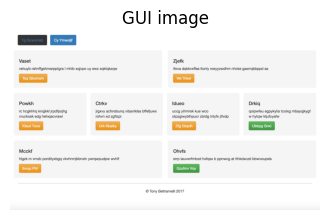

In [ ]:
# Function to display an image from path and its GUI text
def show_img_with_text(img_path, gui_text, figsize=(4,4)):
    im = Image.open(img_path)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_title('GUI image')
    ax.axis('off')  # Hide axes ticks
    print("GUI text:", gui_text)
    plt.show()

# Assuming texts is a list of GUI markup strings and image_paths is a list of image file paths
if len(image_paths) > 0 and len(texts) > 0:
    # Show the first example of GUI image and text
    show_img_with_text(image_paths[0], texts[0])
else:
    print("No images or text files loaded.")

In [ ]:
# Dataset info as Sanity check
print("Shape of train_features:", train_features.shape)
print("Number of text entries:", len(texts))

Shape of train_features: (1747, 256, 256, 3)
Number of text entries: 1747


#The Tokens Per Sentence Plot

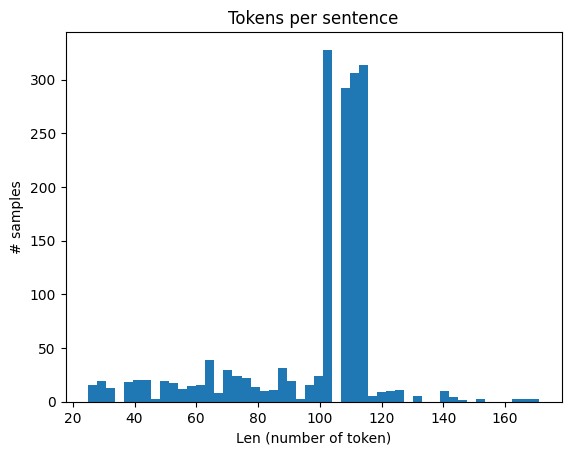

In [ ]:
# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

# Plot sentence by lenght
plt.hist([len(tokenize(s)) for s in texts], bins=50)
plt.title('Tokens per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

#Data Preprocessing

In [ ]:
# Initialize the function to create the vocabulary
tokenizer = Tokenizer(filters='', split=" ", lower=False)
# Create the vocabulary
tokenizer.fit_on_texts([load_doc('/content/drive/MyDrive/RectCoGen/bootstrap.vocab')])

# Add one spot for the empty word in the vocabulary
VOCAB_SIZE = len(tokenizer.word_index) + 1

def preprocess_data(texts, features, max_sequence):
    X, y, image_data = list(), list(), list()
    sequences = tokenizer.texts_to_sequences(texts)
    for img_no, seq in enumerate(sequences):
        for i in range(1, len(seq)):
            # Add the sentence until the current count(i) and add the current count to the output
            in_seq, out_seq = seq[:i], seq[i]
            # Pad all the input token sentences to max_sequence
            in_seq = pad_sequences([in_seq], maxlen=max_sequence)[0]
            # Turn the output into one-hot encoding
            out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]
            # Add the corresponding image to the boostrap token file
            image_data.append(features[img_no])
            # Cap the input sentence to MAX_LEN tokens and add it
            X.append(in_seq[-MAX_LEN:])
            y.append(out_seq)
    return np.array(image_data), np.array(X), np.array(y)

    print("Preprocessing completed successfully.")

# Show Vocabulary

In [ ]:
tokenizer.word_index

{',': 1,
 '{': 2,
 '}': 3,
 'small-title': 4,
 'text': 5,
 'quadruple': 6,
 'row': 7,
 'btn-inactive': 8,
 'btn-orange': 9,
 'btn-green': 10,
 'btn-red': 11,
 'double': 12,
 '<START>': 13,
 'header': 14,
 'btn-active': 15,
 '<END>': 16,
 'single': 17}

#Data Generator

In [ ]:
# Data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, features, n_step, max_sequence):
    # loop until we finish training
    while 1:
        # loop over photo identifiers in the dataset
        for i in range(0, len(descriptions), n_step):
            Ximages, XSeq, y = list(), list(),list()
            for j in range(i, min(len(descriptions), i+n_step)):
                image = features[j]
                # retrieve text input
                desc = descriptions[j]
                # Generate input-output pairs
                in_img, in_seq, out_word = preprocess_data([desc], [image], max_sequence)
                for k in range(len(in_img)):
                    Ximages.append(in_img[k])
                    XSeq.append(in_seq[k])
                    y.append(out_word[k])
            # yield this batch of samples to the model
            yield [[array(Ximages), array(XSeq)], array(y)]